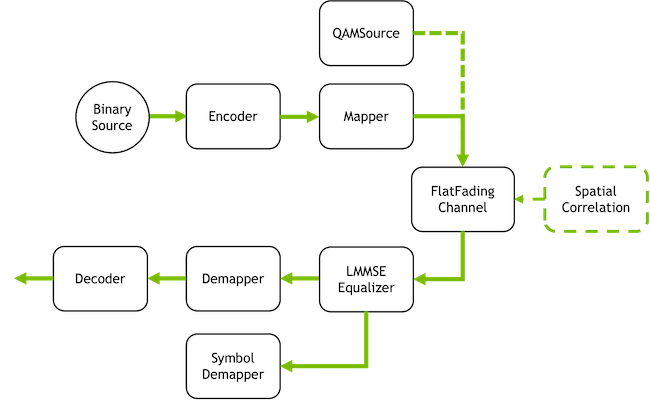

# Uncoded MIMO System with ZF,LMMSE Equalizers

Number of GPUs available : 0
x =
 tf.Tensor(
[[ 0.9486833+0.9486833j -0.3162278+0.9486833j -0.3162278+0.9486833j
   0.9486833-0.9486833j]
 [ 0.3162278-0.3162278j -0.3162278-0.9486833j  0.3162278+0.3162278j
   0.3162278+0.3162278j]
 [ 0.9486833+0.9486833j  0.9486833-0.3162278j -0.3162278+0.9486833j
  -0.3162278-0.3162278j]
 ...
 [ 0.3162278-0.9486833j -0.3162278+0.3162278j -0.9486833-0.3162278j
  -0.3162278+0.3162278j]
 [ 0.9486833-0.3162278j  0.3162278-0.9486833j  0.3162278-0.3162278j
   0.3162278+0.9486833j]
 [-0.9486833-0.3162278j  0.9486833+0.3162278j  0.3162278+0.9486833j
   0.3162278-0.3162278j]], shape=(1024, 4), dtype=complex64)
x.shape =
 (1024, 4)
h.shape =
 (1024, 16, 4)
y.shape =
 (1024, 16)


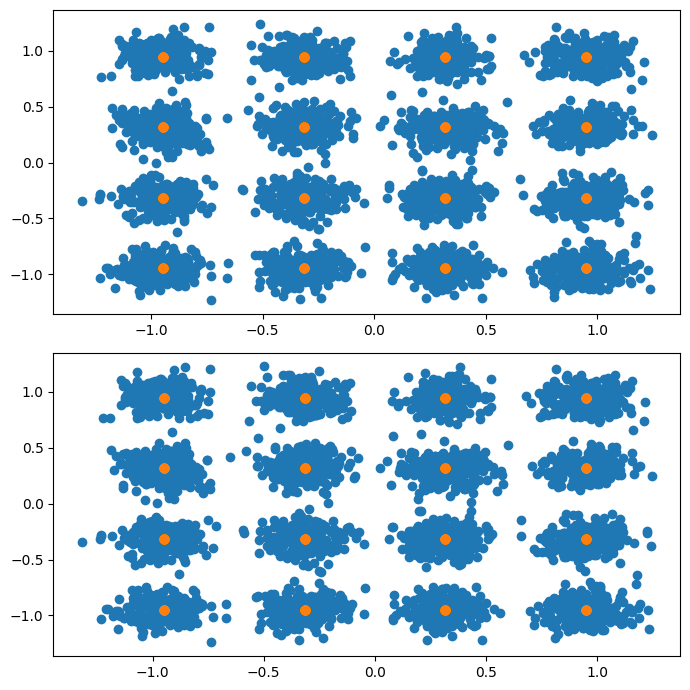

In [3]:
# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

# Simple Uncoded Transmission
NUM_TX_ANT = 4 # Number of Transmitter Antennas
NUM_RX_ANT = 16 # Number of Receiver Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 1024 # Parallel in 3 batches
qam_source = QAMSource(NUM_BITS_PER_SYMBOL)
x = qam_source([BATCH_SIZE, NUM_TX_ANT])
print('x =\n',x)
print('x.shape =\n',x.shape)

# Create `FlatFadingChannel` to simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)
no = 0.2 # Noise Variance of the Transmission Channel

# y and h are the Channel Output and Channel Realizations, respectively.
y, h = channel([x, no]) # x = qam_source([batch_size, num_tx_ant]), no = 0.2
print('h.shape =\n',h.shape)
print('y.shape =\n',y.shape)

s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)
x_hat_zf, no_eff_zf = zf_equalizer(y, h, s)
x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)

# plt.axes().set_aspect(1.0)
# plt.scatter(np.real(x_hat_zf), np.imag(x_hat_zf));
# plt.scatter(np.real(x), np.imag(x));

plt.figure(figsize=(7,7))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.subplot(2,1,1)
plt.scatter(np.real(x_hat_zf), np.imag(x_hat_zf));
plt.scatter(np.real(x), np.imag(x));
plt.subplot(2,1,2)
plt.scatter(np.real(x_hat_lmmse), np.imag(x_hat_lmmse));
plt.scatter(np.real(x), np.imag(x));
# plt.subplot(3,1,3)
# plt.scatter(tf.math.real(y_3), tf.math.imag(y_3))
plt.tight_layout()



# Uncoded MIMO SER

Number of GPUs available : 0
b shape = (2000, 4, 512)
x shape = (2000, 4, 128)
x reshape = (256000, 4)


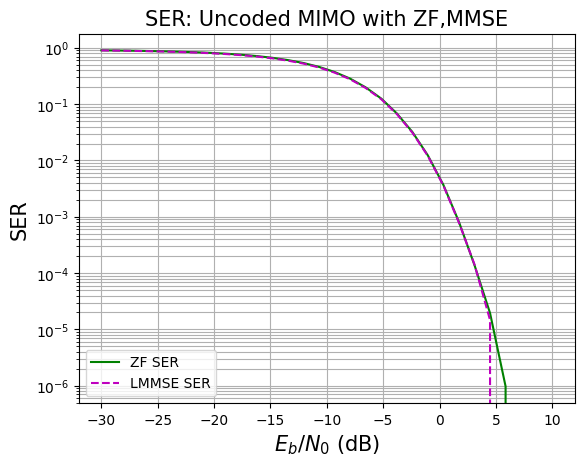

In [53]:
# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

import tensorflow as tf
# For the implementation of the Keras models
from tensorflow import keras
from keras import Model
# for performance measurements
import time

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber

# Binary Source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)

# SymbolDemapper
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)

k = 512 # Block Length
# no = 0.2 # Noise variance of the channel
NUM_TX_ANT = 4 # Transmit Antennas
NUM_RX_ANT = 16 # Receive Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 2000 # Parallelly Processed Batches
EBN0_DB_MIN = -30.0 # Minimum Eb/N0 [dB]
EBN0_DB_MAX = 10.0 # Maximum Eb/N0 [dB]
snrs = []
bers = []
sers_zf = []
sers_lmmse = []

b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
print('b shape =',b.shape)

x = mapper(b)
print('x shape =',x.shape)

shape = tf.shape(x)
x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
print('x reshape =',x_reshape.shape)

# Tx_Symbols = bits2symbol(b,NUM_BITS_PER_SYMBOL)
# print('Tx_Symbols =',Tx_Symbols)



for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,30):

    snrs += [EBN0_DB]

    no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
    # print('no =',no)

    x_ind = symbol_demapper([x, no])
    # print('x_ind.shape =',x_ind.shape)

    # y and h are the Channel Output and Channel Realizations, respectively.
    y, h = flatfading_channel([x_reshape, no])
    # print('h.shape =\n',h.shape)
    # print('y.shape =\n',y.shape)

    s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)

    x_hat_zf, no_eff_zf = zf_equalizer(y, h, s)
    # print('x_hat_zf.shape =',x_hat_zf.shape)
    x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)
    # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

    x_hat_zf = tf.reshape(x_hat_zf, shape)
    # print('x_hat_zf.shape =',x_hat_zf.shape)
    x_hat_lmmse = tf.reshape(x_hat_lmmse, shape)
    # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

    no_eff_zf = tf.reshape(no_eff_zf, shape)
    no_eff_lmmse = tf.reshape(no_eff_lmmse, shape)

    # llr_zf = demapper([x_hat_zf, no_eff_zf])
    # b_hat_zf = decoder(llr_zf)

    x_ind_hat_zf = symbol_demapper([x_hat_zf, no])
    # print('x_ind_hat_zf.shape =',x_ind_hat_zf.shape)
    x_ind_hat_lmmse = symbol_demapper([x_hat_lmmse, no])
    # print('x_ind_hat_lmmse.shape =',x_ind_hat_lmmse.shape)

    ser_zf = compute_ser(x_ind, x_ind_hat_zf)
    ser_lmmse = compute_ser(x_ind, x_ind_hat_lmmse)
    sers_zf += [ser_zf]
    sers_lmmse += [ser_lmmse]

# print(snrs)
# print(sers_zf)
# print(sers_lmmse)
title = "SER: Uncoded MIMO with ZF,MMSE"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "SER"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
# plt.semilogy(snrs, bers, 'b', label='Uncoding BER')
plt.semilogy(snrs, sers_zf, 'g', label='ZF SER')
# plt.semilogy(snrs, bers_LDPC, 'r--', label='LDPC BER')
plt.semilogy(snrs, sers_lmmse, 'm--', label='LMMSE SER')
plt.legend(loc='lower left', fontsize=10)
plt.show()

# plt.figure(figsize=(7,7))
# plt.axes().set_aspect(1)
# plt.grid(True)
# plt.title('Channel output')
# plt.xlabel('Real Part')
# plt.ylabel('Imaginary Part')
# plt.subplot(2,1,1)
# plt.scatter(np.real(x_hat_zf), np.imag(x_hat_zf))
# plt.scatter(np.real(x), np.imag(x))
# plt.subplot(2,1,2)
# plt.scatter(np.real(x_hat_lmmse), np.imag(x_hat_lmmse))
# plt.scatter(np.real(x), np.imag(x))
# # plt.subplot(3,1,3)
# # plt.scatter(tf.math.real(y_3), tf.math.imag(y_3))
# plt.tight_layout()



# Coded MIMO BER